<img src="logo.png">
## RNNs in Signal Processing and Human System Interaction
### PART 2: RNNs in Human System Interaction - Classification

In this part we will focus on classification utilizing variable length sequences.<br>
Data: sequences of 3 values in a timestamp. Normalized to <-1,1>. Proportions in training/testing/validation set: 60%/20%/20%.

Let's import some libs:

In [1]:
%run Functions.ipynb
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\qlast\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_classes = 6          #-number of classes
act_fcn=tf.nn.relu

class_names = ['fast swipe','slow swipe','pose','1 cut','2 cuts','ellipse']

Data loader - we are going to load 3 files for each of training, validation and testing sets:  
Inputs (files with data sequences/timestamps), Lengths (length of each sequence), Targets (not one hot encoded)


In [3]:
I_train, L_train, T_train, = readIt('train')
I_test,  L_test,  T_test   = readIt('test')
I_valid, L_valid, T_valid  = readIt('valid')

In [4]:
I_train.shape

(137315, 8)

In [5]:
L_train.shape

(1800, 1)

(1000, 1500)

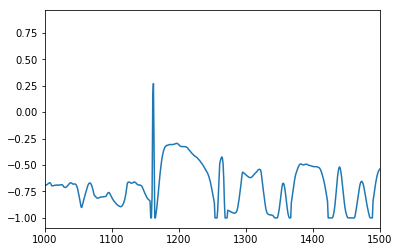

In [6]:
plt.plot(I_train[:,4])
plt.xlim((1000,1500))

We need the variable length sequences to be zero-padded in the timestamp dim (in reference to the longest sequence).

In [7]:
n_inputs = I_test.shape[1]
n_steps = np.max([max(L_train), max(L_test), max(L_valid)])

I_train, T_train, L_train = ReshapeMyData(I_train, L_train, T_train, n_inputs, n_steps) 
I_test,  T_test,  L_test  = ReshapeMyData(I_test,  L_test,  T_test,  n_inputs, n_steps)  
I_valid, T_valid, L_valid = ReshapeMyData(I_valid, L_valid, T_valid, n_inputs, n_steps) 

n_steps = np.max([max(L_train), max(L_test), max(L_valid)])

print('I_train ',I_train.shape)

I_train  (1800, 165, 8)


54


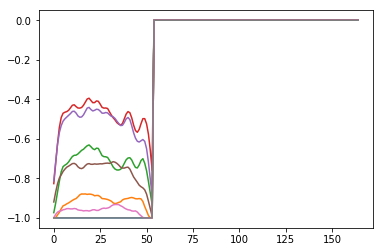

In [8]:
test_case=30
plt.plot(I_train[test_case,:,:])
print(L_train[test_case])

In [9]:
# scale inputs to the range <0;1>
if(act_fcn==tf.nn.relu):
    I_train = (I_train+1)/2
    I_valid = (I_valid+1)/2
    I_test  = (I_test+1)/2

For testing purposes let's produce another set:

In [10]:
import math

I_test_h = np.zeros(I_test.shape)
L_test_h = np.zeros(L_test.shape)
L_test_h = L_test_h.astype(int)

for it in range(I_test.shape[0]):
    L_test_h[it] = L_test[it]/2
    I_test_h[it,range(L_test_h[it]),:] = I_test[it,L_test_h[it]:L_test_h[it]*2,:]

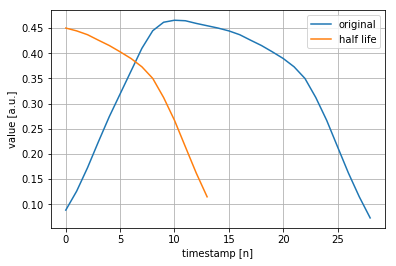

In [11]:
testing_sequence = 5
testing_feature = 3
plt.plot(range(L_test[testing_sequence]),   I_test[testing_sequence,  range(L_test[testing_sequence]),  testing_feature], label='original')
plt.plot(range(L_test_h[testing_sequence]), I_test_h[testing_sequence,range(L_test_h[testing_sequence]),testing_feature], label='half life')
plt.legend()
plt.xlabel('timestamp [n]')
plt.ylabel('value [a.u.]')
plt.grid()

In [12]:
def run_model(selected_cell, Train_FLAG=False, TBoard_FLAG=False):
    #top_o, top_h = 0
    
    %run Functions.ipynb
    
    tf.reset_default_graph()        
    our_seed = 2018
    np.random.seed(seed=our_seed)
    tf.set_random_seed(seed=our_seed)    
        
    #---placeholders    
    X = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs])
    y = tf.placeholder(dtype=tf.int32,   shape=[None])
    seq_length = tf.placeholder(dtype=tf.int32, shape=[None])
    
    #---building the graph
    temp_cell = selected_cell(num_units = n_neurons, activation=act_fcn)        
       
    #---look for optional param in dynamic_rnn: sequnence_length
    #- optional but super important!
    outputs, states = tf.nn.dynamic_rnn(temp_cell, X, dtype=tf.float32, sequence_length=seq_length)    
    
    #---take output from only last time stamp of given sequence
    last = last_relevant(outputs, seq_length)
    logits = tf.layers.dense(last, n_classes)
    
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)        
    #training_op = optimizer.minimize(loss) # first training_op

    
    # GC  (comment out first training_op)
    gradients, variables =  zip(*optimizer.compute_gradients(loss))
    #gradients = [None if gradient is None else tf.clip_by_value(gradient, clip_value_min=-0.15, clip_value_max=0.25) for gradient in gradients]                 
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_norm=0.35) for gradient in gradients]        
    training_op = optimizer.apply_gradients(zip(gradients, variables))    
    
    for index, grad in enumerate(gradients):                           
        tf.summary.histogram("{}-grad".format(gradients[index][1].name.replace(":","-")),gradients[index])

    
    correct = tf.nn.in_top_k(logits, y, 1)
    top_result = tf.argmax(logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    init = tf.global_variables_initializer()         
    
    #--TensorBoard
    tf.summary.scalar('LOSS',loss)    
    tf.summary.scalar('ACC',accuracy)        
    summaries = tf.summary.merge_all()
    
    if(Train_FLAG):
        #--- Evaluate the graph ----------------------------------------------
        with tf.Session() as sess:

            if(TBoard_FLAG):
                file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph()) 
            
            sess.run(init)
            valid_best = 0.0
            acc_test_o = 0.0
            acc_test_h = 0.0

            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(L_train),)
                for rnd_indices in np.array_split(rnd_idx, len(L_train) // minibatch_size):
                    X_batch, y_batch, l_batch = I_train[rnd_indices, :, :], T_train[rnd_indices], L_train[rnd_indices]

                    sess.run(training_op, feed_dict={X: X_batch,   y: y_batch,   seq_length: l_batch})

                if(TBoard_FLAG):
                    lsum = sess.run(summaries, feed_dict={X: I_valid, y: T_valid, seq_length: L_valid})
                    file_writer.add_summary(lsum, epoch+1)

                acc_train = sess.run(accuracy, feed_dict={X: X_batch,   y: y_batch,   seq_length: l_batch})
                acc_valid = sess.run(accuracy, feed_dict={X: I_valid,   y: T_valid,   seq_length: L_valid})

                print("Epoch: {0}\tMinibatch acc.: {1:.2f}%\t Validation set acc.: {2:.2f}%".
                      format(epoch+1, 100 * acc_train, 100*acc_valid))    

                if(acc_valid>valid_best):
                    valid_best=acc_valid

                    acc_test_o = sess.run(accuracy, feed_dict={X: I_test,   y: T_test, seq_length: L_test})                
                    acc_test_h = sess.run(accuracy, feed_dict={X: I_test_h, y: T_test, seq_length: L_test_h})                                                

                    top_o = sess.run(top_result, feed_dict={X: I_test,   y: T_test, seq_length: L_test})                
                    top_h = sess.run(top_result, feed_dict={X: I_test_h, y: T_test, seq_length: L_test_h})     

            print("\nBest validation set accuracy:\t{0:.3f}%".format(100 * valid_best))    
            print("Original test set accuracy:\t{0:.3f}%".format(100 * acc_test_o))
            print("Half life test set accuracy:\t{0:.3f}%".format(100 * acc_test_h))
            
            if(TBoard_FLAG):
                file_writer.close()
            
    return top_o, top_h

In [13]:
#--for TensorBoard
now = datetime.utcnow().strftime("%H.%M.%S") #name for TBoard
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir,now+"_GCbyNorm")

n_epochs = 15          #-number of epochs to perform
n_neurons = 20         #-number of neurons/memory cells
minibatch_size = 16    #-minibatch size

#learning_rate = 0.004  #-learning rate
learning_rate = 0.04   #-learning rate - grad. clipping tests

selected_cell = tf.nn.rnn_cell.BasicLSTMCell

start = time.time()
top_o, top_h = run_model(selected_cell, Train_FLAG=True, TBoard_FLAG=True)
end = time.time()
print("Training time: {0:.2f}s".format(end-start))

C:\Users\qlast\Anaconda3\envs\py35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 1	Minibatch acc.: 87.50%	 Validation set acc.: 79.33%
Epoch: 2	Minibatch acc.: 87.50%	 Validation set acc.: 76.50%
Epoch: 3	Minibatch acc.: 81.25%	 Validation set acc.: 83.33%
Epoch: 4	Minibatch acc.: 81.25%	 Validation set acc.: 85.33%
Epoch: 5	Minibatch acc.: 87.50%	 Validation set acc.: 85.50%
Epoch: 6	Minibatch acc.: 87.50%	 Validation set acc.: 86.67%
Epoch: 7	Minibatch acc.: 87.50%	 Validation set acc.: 82.33%
Epoch: 8	Minibatch acc.: 100.00%	 Validation set acc.: 92.17%
Epoch: 9	Minibatch acc.: 81.25%	 Validation set acc.: 95.50%
Epoch: 10	Minibatch acc.: 100.00%	 Validation set acc.: 95.33%
Epoch: 11	Minibatch acc.: 81.25%	 Validation set acc.: 92.50%
Epoch: 12	Minibatch acc.: 100.00%	 Validation set acc.: 96.33%
Epoch: 13	Minibatch acc.: 100.00%	 Validation set acc.: 96.83%
Epoch: 14	Minibatch acc.: 100.00%	 Validation set acc.: 96.67%
Epoch: 15	Minibatch acc.: 100.00%	 Validation set acc.: 97.67%

Best validation set accuracy:	97.667%
Original test set accuracy:	97.333

Let's look how gradient clipping methods helped to achieve better classification results for the same set of hyperparameters in comparison to no GC training in this case. It is good to use GC when executing numerous trainings e.g. in random search method.

<img src="gc1.png">

Ok, so let's take a closer look how gradients are clipped on the example of one of gradients from the graph:
<img src="gc2.png">

In [14]:
from sklearn.metrics import confusion_matrix as cm
myConfusionMatrix_o = cm(T_test,top_o)
myConfusionMatrix_h = cm(T_test,top_h)

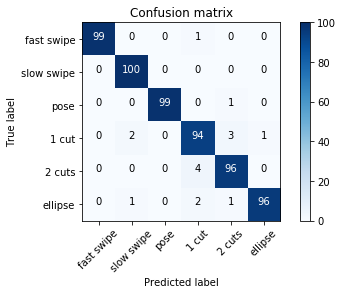

In [15]:
plt.figure()
plot_confusion_matrix(myConfusionMatrix_o, classes=class_names)

In [16]:
divisor = 1.0
diagonals_o = [myConfusionMatrix_o[i][i]/divisor for i in range(n_classes)]
diagonals_h = [myConfusionMatrix_h[i][i]/divisor for i in range(n_classes)]

median_class=[]
mean_class = []

for class_no in range(n_classes):
    indeksy = np.where(T_train==class_no)
    median_class.append( np.median( L_train[indeksy]) )
    mean_class.append(   np.mean(   L_train[indeksy]) )

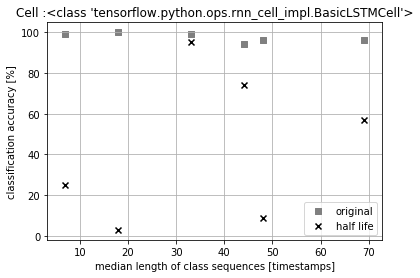

In [17]:
plt.scatter(median_class,diagonals_o, label='original',  marker='s', color='gray')
plt.scatter(median_class,diagonals_h, label='half life', marker='x', color='black')
plt.grid()
plt.legend()
plt.title('Cell :{}'.format(selected_cell))
plt.xlabel('median length of class sequences [timestamps]')
plt.ylabel('classification accuracy [%]')

In [18]:
np.sort(median_class)

array([ 7., 18., 33., 44., 48., 69.])